## Final Project Submission

Please fill out:
* Student name: Daniel Quillao
* Student pace: Self-paced
* Scheduled project review date/time: TBD
* Instructor name: Jeff Herman
* Blog post URL:

# 1. Obtain Data

In [522]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

import scipy.stats as stats

import pickle

In [523]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# 2. Scrub and Clean Data

In [524]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Check for erroneous values

In [525]:
# Preview the 5 most frequent entries from each column
for col in df.columns:
    try:
        print(col, df[col].value_counts()[:5])
    except:
        print(col, df[col].value_counts())
        # If there aren't 5+ unique values for a column the first print statement
        # will throw an error for an invalid idx slice
    print('\n') # Break up the output between columns

id 795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
Name: id, dtype: int64


date 6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
Name: date, dtype: int64


price 350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64


bedrooms 3    9824
4    6882
2    2760
5    1601
6     272
Name: bedrooms, dtype: int64


bathrooms 2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
Name: bathrooms, dtype: int64


sqft_living 1300    138
1400    135
1440    133
1660    129
1010    129
Name: sqft_living, dtype: int64


sqft_lot 5000    358
6000    290
4000    251
7200    220
7500    119
Name: sqft_lot, dtype: 

Notes: sqft_basement change to float, update '?' values

In [526]:
# sqft_basement: check for instances of '?'
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
506.0         1
248.0         1
1816.0        1
652.0         1
1960.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [527]:
# Drop rows as it only accounts for 2% of the data
df = df.drop(df[df['sqft_basement']=='?'].index)

In [528]:
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'])

## Check for nulls

In [529]:
# Check sum of nulls
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2339
view               61
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3754
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Note: Check waterfront, view, and yr_renovated

In [530]:
# Get statistics
df[['waterfront', 'view', 'yr_renovated']].describe()

,waterfront,view,yr_renovated
count,18804.000000,21082.000000,17389.000000
mean,0.007552,0.233327,82.991949
std,0.086573,0.765066,398.481819
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,4.000000,2015.000000


In [531]:
null_list = ['waterfront', 'view', 'yr_renovated']

for feature in null_list:
    print(df[feature].value_counts())

0.0    18662
1.0      142
Name: waterfront, dtype: int64
0.0    19018
2.0      930
3.0      496
1.0      327
4.0      311
Name: view, dtype: int64
0.0       16666
2014.0       69
2003.0       31
2013.0       31
2007.0       30
          ...  
1953.0        1
1944.0        1
1934.0        1
1971.0        1
1959.0        1
Name: yr_renovated, Length: 69, dtype: int64


Notes:
- waterfront has 2339 null values
- view has 61 null values
- yr_renovated has 3754 null values
- The majority of the data is 0 for these features. Update null values to 0.

In [532]:
# Update null values to 0
df.fillna(0, inplace = True)

In [533]:
# Double-check for null values
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [534]:
# Check for duplicates
print(len(df[df.duplicated()]))

0


# 4. Explore Data

## Feature Engineering

Notes:
- yr_renovated: convert to binary {0: not renovated, 1: renovated}
- sqft_basement: convert to binary {0: no basement, 1: has basement}
- waterfront: convert to binary {0: no waterfront, 1: has waterfront}
- date and id: not useful, drop
- lat and long: should be categorical, however might be better to drop (i think zip code will be a similar/better feauture)
- convert zip code to priced tier ranks (1-10)

In [535]:
# yr_renovated
df['yr_renovated'].value_counts()

0.0       20420
2014.0       69
2003.0       31
2013.0       31
2007.0       30
          ...  
1953.0        1
1944.0        1
1934.0        1
1971.0        1
1959.0        1
Name: yr_renovated, Length: 69, dtype: int64

In [536]:
# Create new column renovated
df['renovated'] = df['yr_renovated'].map(lambda x: 1 if x > 0 else 0)
# Drop yr_renovated column
df = df.drop('yr_renovated', axis=1)

In [537]:
# Check new column
df['renovated'].value_counts()

0    20420
1      723
Name: renovated, dtype: int64

In [538]:
# sqft_basement
df['sqft_basement'].value_counts()

0.0       12826
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Length: 303, dtype: int64

In [539]:
# Create new column basement
df['basement'] = df['sqft_basement'].map(lambda x: 1 if x > 0 else 0)
# Drop sqft_basement column
df = df.drop('sqft_basement', axis=1)

In [540]:
# Check new column
df['basement'].value_counts()

0    12826
1     8317
Name: basement, dtype: int64

In [541]:
# view
df['view'].value_counts()

0.0    19079
2.0      930
3.0      496
1.0      327
4.0      311
Name: view, dtype: int64

In [542]:
# Update view
df['view'] = df['view'].map(lambda x: 1 if x > 0 else 0)

In [543]:
# Check view
df['view'].value_counts()

0    19079
1     2064
Name: view, dtype: int64

In [544]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   date           21143 non-null  object 
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     21143 non-null  float64
 9   view           21143 non-null  int64  
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  yr_built       21143 non-null  int64  
 14  zipcode        21143 non-null  int64  
 15  lat            21143 non-null  float64
 16  long           21143 non-null  float64
 17  sqft_living15  21143 non-null  int64  
 18  sqft_l

In [545]:
# waterfront
df['waterfront'].value_counts()

0.0    21001
1.0      142
Name: waterfront, dtype: int64

In [546]:
# Update waterfront
df['waterfront'] = df['waterfront'].map(lambda x: 1 if x > 0 else 0)

In [547]:
# Check waterfront
df['waterfront'].value_counts()

0    21001
1      142
Name: waterfront, dtype: int64

In [548]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   date           21143 non-null  object 
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     21143 non-null  int64  
 9   view           21143 non-null  int64  
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  yr_built       21143 non-null  int64  
 14  zipcode        21143 non-null  int64  
 15  lat            21143 non-null  float64
 16  long           21143 non-null  float64
 17  sqft_living15  21143 non-null  int64  
 18  sqft_l

In [549]:
# Drop unnecessary columns
df.drop(columns=['date', 'id', 'lat', 'long'], inplace=True) 

In [550]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21143 non-null  float64
 1   bedrooms       21143 non-null  int64  
 2   bathrooms      21143 non-null  float64
 3   sqft_living    21143 non-null  int64  
 4   sqft_lot       21143 non-null  int64  
 5   floors         21143 non-null  float64
 6   waterfront     21143 non-null  int64  
 7   view           21143 non-null  int64  
 8   condition      21143 non-null  int64  
 9   grade          21143 non-null  int64  
 10  sqft_above     21143 non-null  int64  
 11  yr_built       21143 non-null  int64  
 12  zipcode        21143 non-null  int64  
 13  sqft_living15  21143 non-null  int64  
 14  sqft_lot15     21143 non-null  int64  
 15  renovated      21143 non-null  int64  
 16  basement       21143 non-null  int64  
dtypes: float64(3), int64(14)
memory usage: 2.9 MB


## Tranform zipcode in price tier ranks (1-10)

In [551]:
df.zipcode.value_counts()

98103    588
98038    574
98115    568
98052    562
98042    542
        ... 
98102    100
98010     98
98024     79
98148     55
98039     49
Name: zipcode, Length: 70, dtype: int64

In [552]:
# Create copy
rank_df = df.copy()

In [553]:
# Groupby zipcode and take median price
zip_med_df = rank_df.groupby(rank_df['zipcode'])['price'].median().sort_values(ascending = False)

# Reset index after groupy
zip_med_df = zip_med_df.reset_index()

# Set as string to match
zip_med_df['zipcode'] = zip_med_df['zipcode'].astype('object')

zip_med_df.head(10)

,zipcode,price
0,98039,1880000.0
1,98004,1150000.0
2,98040,994000.0
3,98112,920000.0
4,98005,762450.0
5,98006,760184.5
6,98119,750000.0
7,98075,745000.0
8,98109,736000.0
9,98102,695000.0


In [554]:
# https://stackoverflow.com/questions/60255203/how-to-label-every-nth-row-of-a-pandas-dataframe-by-an-incremental-value
zip_med_df['rank'] = np.divmod(np.arange(len(zip_med_df)),7)[0]+1

In [555]:
zip_med_df.head(21)

,zipcode,price,rank
0,98039,1880000.0,1
1,98004,1150000.0,1
2,98040,994000.0,1
3,98112,920000.0,1
4,98005,762450.0,1
5,98006,760184.5,1
6,98119,750000.0,1
7,98075,745000.0,2
8,98109,736000.0,2
9,98102,695000.0,2


In [556]:
zip_med_df.groupby(['rank'])['price'].median()

rank
1     920000.0
2     689900.0
3     575000.0
4     550000.0
5     470000.0
6     425000.0
7     375250.0
8     315000.0
9     279500.0
10    260000.0
Name: price, dtype: float64

In [557]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15,renovated,basement
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,1955,98178,1340,5650,0,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,1951,98125,1690,7639,1,1
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,1933,98028,2720,8062,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,1965,98136,1360,5000,0,1
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,1987,98074,1800,7503,0,0


In [558]:
zip_med_df.drop(['price'], axis = 1, inplace = True)

In [559]:
df = pd.merge(df, zip_med_df, on='zipcode')

In [560]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15,renovated,basement,rank
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,1955,98178,1340,5650,0,0,9
1,205425.0,2,1.00,880,6780,1.0,0,0,4,6,880,1945,98178,1190,6780,0,0,9
2,445000.0,3,2.25,2100,8201,1.0,0,1,3,8,1620,1967,98178,2660,8712,0,1,9
3,236000.0,3,1.00,1300,5898,1.0,0,0,3,7,1300,1961,98178,1320,7619,0,0,9
4,170000.0,2,1.00,860,5265,1.0,0,0,3,6,860,1931,98178,1650,8775,0,0,9


In [561]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21142
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21143 non-null  float64
 1   bedrooms       21143 non-null  int64  
 2   bathrooms      21143 non-null  float64
 3   sqft_living    21143 non-null  int64  
 4   sqft_lot       21143 non-null  int64  
 5   floors         21143 non-null  float64
 6   waterfront     21143 non-null  int64  
 7   view           21143 non-null  int64  
 8   condition      21143 non-null  int64  
 9   grade          21143 non-null  int64  
 10  sqft_above     21143 non-null  int64  
 11  yr_built       21143 non-null  int64  
 12  zipcode        21143 non-null  object 
 13  sqft_living15  21143 non-null  int64  
 14  sqft_lot15     21143 non-null  int64  
 15  renovated      21143 non-null  int64  
 16  basement       21143 non-null  int64  
 17  rank           21143 non-null  int64  
dtypes: flo

In [562]:
df.sort_values('price')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15,renovated,basement,rank
16736,78000.0,2,1.00,780,16344,1.0,0,0,1,5,780,1942,98168,1700,10387,0,0,10
20712,80000.0,1,0.75,430,5050,1.0,0,0,2,4,430,1912,98014,1200,7500,0,0,6
16746,81000.0,2,1.00,730,9975,1.0,0,0,1,5,730,1943,98168,860,9000,0,0,10
2393,82000.0,3,1.00,860,10426,1.0,0,0,3,6,860,1954,98146,1140,11250,0,0,8
16567,82500.0,2,1.00,520,22334,1.0,0,0,2,5,520,1951,98168,1572,10570,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,5350000.0,5,5.00,8000,23985,2.0,0,1,3,12,6720,2009,98004,4600,21750,0,1,1
21099,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,2001,98039,3560,24345,0,1,1
21106,6890000.0,6,7.75,9890,31374,2.0,0,1,3,13,8860,2001,98039,4540,42730,0,1,1
13284,7060000.0,5,4.50,10040,37325,2.0,1,1,3,11,7680,1940,98004,3930,25449,1,1,1


## Check for outliers

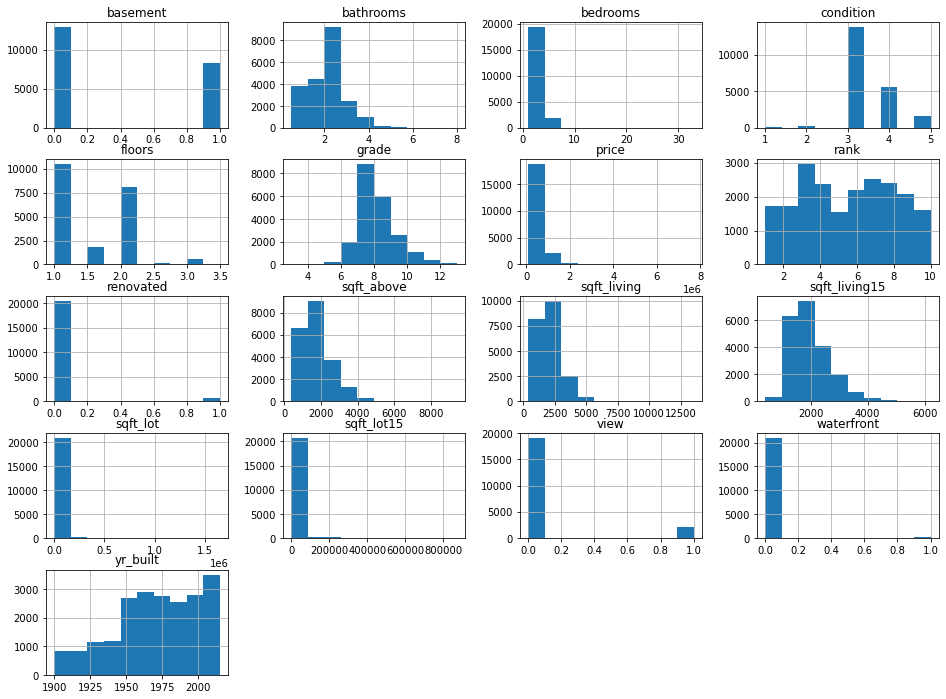

In [563]:
df.hist(figsize=(16, 12));

In [564]:
# Removes feats with z-score above 3 for specific columns
# Reference https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame

outlier_feats = ['price', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_above', 'bathrooms', 'bedrooms', 'floors']

for feat in outlier_feats:
    df = df[np.abs(df[feat]-df[feat].mean()) <= (3*df[feat].std())]

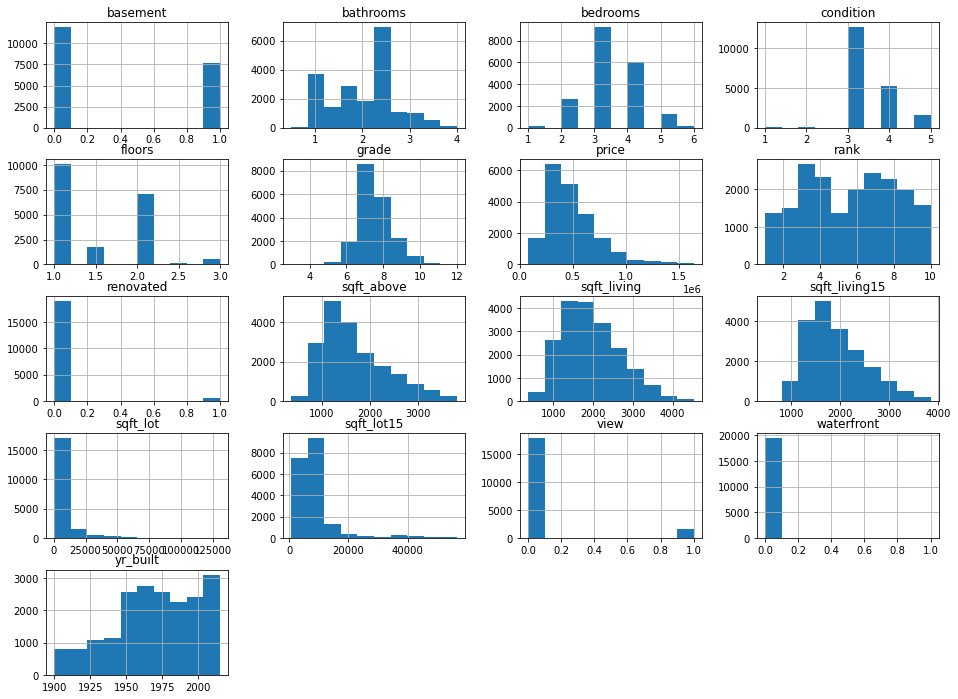

In [565]:
df.hist(figsize=(16,12));

In [566]:
df.floors.value_counts()

1.0    10054
2.0     7061
1.5     1752
3.0      564
2.5      114
Name: floors, dtype: int64

In [567]:
df.bedrooms.value_counts()

3    9220
4    6058
2    2614
5    1274
6     196
1     183
Name: bedrooms, dtype: int64

In [568]:
df.bathrooms.value_counts()

2.50    4976
1.00    3694
1.75    2900
2.25    1930
2.00    1816
1.50    1394
2.75    1069
3.00     646
3.50     512
3.25     400
3.75      75
0.75      67
4.00      54
1.25       9
0.50       3
Name: bathrooms, dtype: int64

## Check for linearity: Joint Plots

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warning

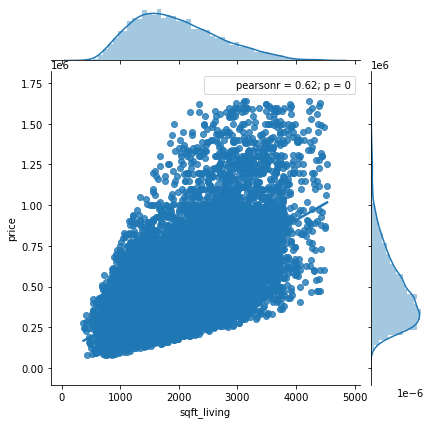

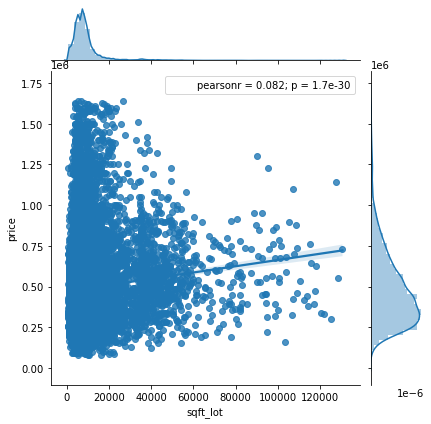

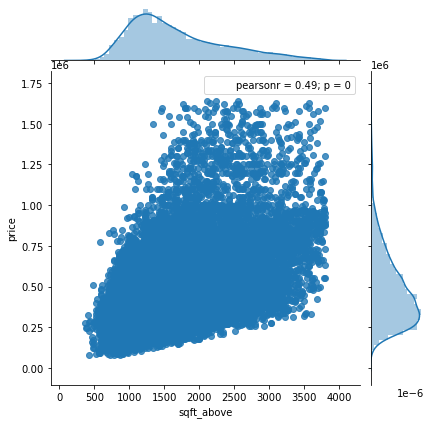

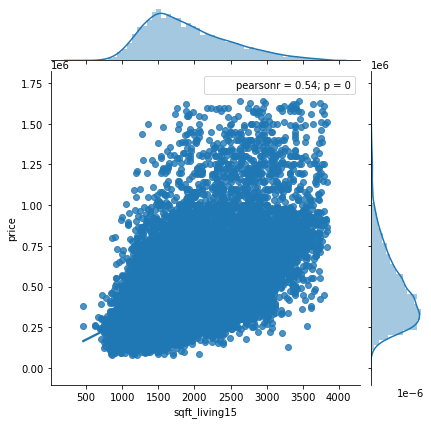

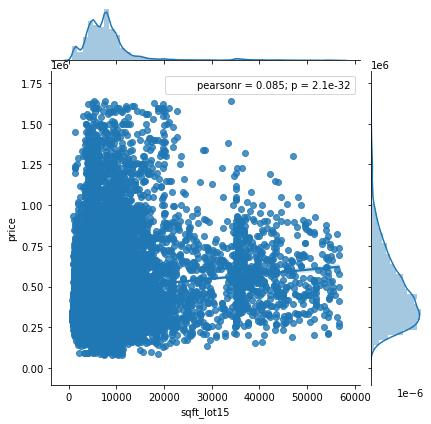

In [569]:
# Plot joint plots
joint_feats = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']

for feat in joint_feats:
    j = sns.jointplot(x = df[feat], y = df['price'], kind = 'reg')
    j.annotate(stats.pearsonr)

Note: sqft_living, sqft_above, and sqft_living15 have a moderate linear relationship with price

## Check for linearity: Box Plots

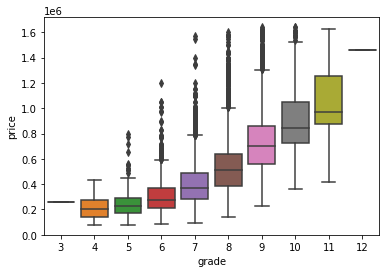

In [570]:
sns.boxplot(x = df['grade'], y = df['price'])

Note: Strong relationship with price

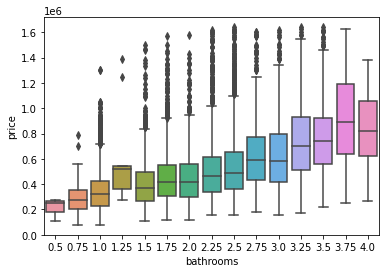

In [571]:
sns.boxplot(x = df['bathrooms'], y = df['price'])

Note: Strong relationship with price

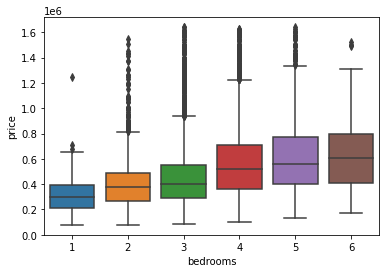

In [572]:
sns.boxplot(x = df['bedrooms'], y = df['price'])

Note: Moderate relationship with price

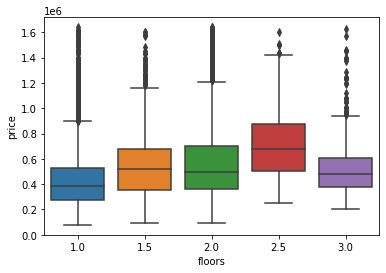

In [573]:
sns.boxplot(x = df['floors'], y = df['price'])

Note: Not much of a relationship with price

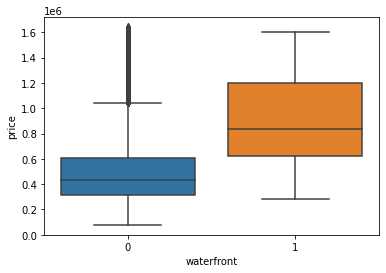

In [574]:
sns.boxplot(x = df['waterfront'], y = df['price'])

Note: Strong relationship with price

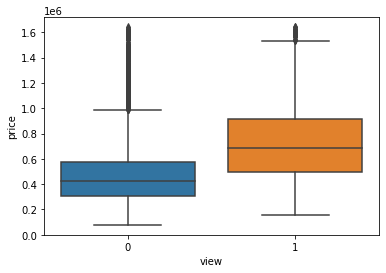

In [575]:
sns.boxplot(x = df['view'], y = df['price'])

Note: Moderate relationship with price

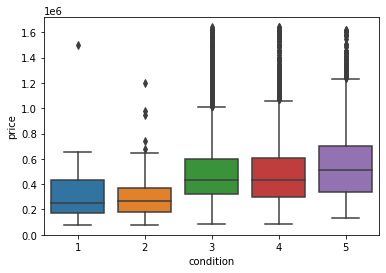

In [576]:
sns.boxplot(x = df['condition'], y = df['price'])

Note: Not much of a relationship with price. Looks like there's an outlier as well in Condition 1.

In [577]:
# con_out_df = df[['condition', 'price']]

In [578]:
# con_1_df = con_out_df[con_out_df['condition'] == 1]
# con_1_df.describe()

In [579]:
# row_to_drop = con_out_df[(con_out_df['condition'] == 1) & (con_out_df['price'] >= 1500000)]

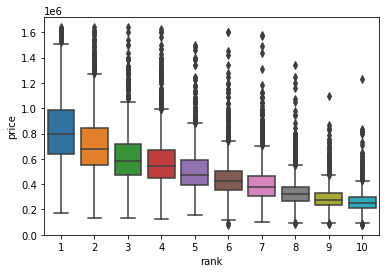

In [580]:
sns.boxplot(x = df['rank'], y = df['price'])

Note: Strong relationship with price

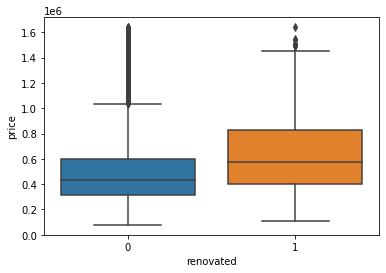

In [581]:
sns.boxplot(x = df['renovated'], y = df['price'])

Note: Not much of a relationship with price

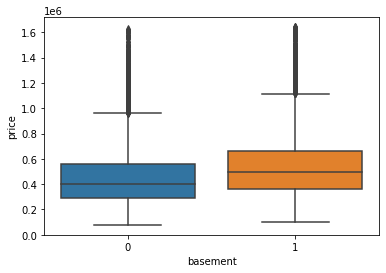

In [582]:
sns.boxplot(x = df['basement'], y = df['price'])

Note: Not much of a relationship with price

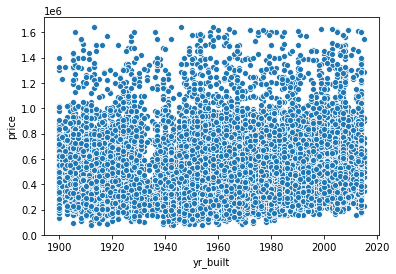

In [583]:
sns.scatterplot(x = df['yr_built'], y = df['price'])

Note: No relationship with price

## Normalize Continuous Features

In [584]:
# Log transform to reduce skewness
# Remember that you can't take the logarithm of zero nor a negative number
log_feats = ['price', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_above', 'bedrooms', 'bathrooms', 'floors']
for var in log_feats:
    df[var]= np.log(df[var])

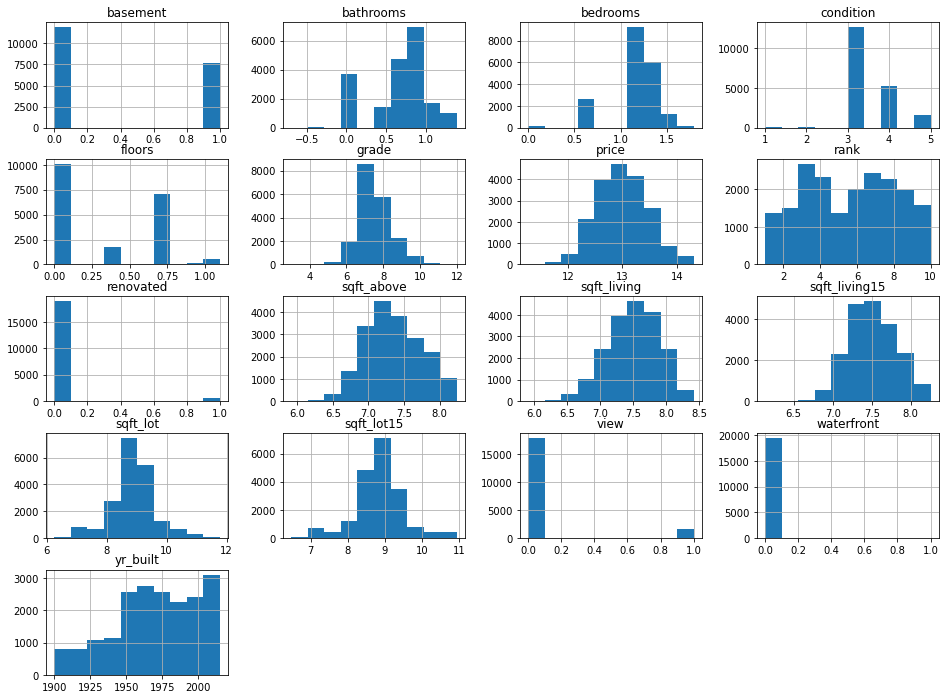

In [585]:
df.hist(figsize = (16,12));

In [586]:
# Standardization (z-score normalization)
# x' will have mean  𝜇=0  and  𝜎=1 
# Note that standardization does not make data more normal, it will just change the mean and the standard error

continuous_feats = ['price', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_above', 'bedrooms', 'bathrooms', 'floors']

for var in continuous_feats:
    df[var] = (df[var] - df[var].mean()) / df[var].std()

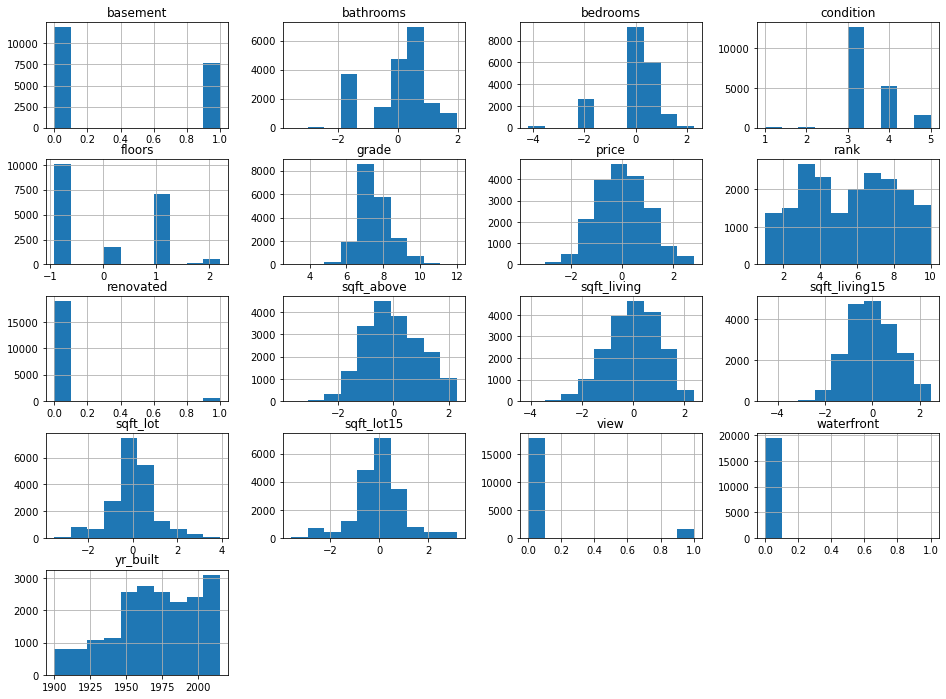

In [587]:
df.hist(figsize = (16, 12));

In [588]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19545 entries, 0 to 21135
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          19545 non-null  float64
 1   bedrooms       19545 non-null  float64
 2   bathrooms      19545 non-null  float64
 3   sqft_living    19545 non-null  float64
 4   sqft_lot       19545 non-null  float64
 5   floors         19545 non-null  float64
 6   waterfront     19545 non-null  int64  
 7   view           19545 non-null  int64  
 8   condition      19545 non-null  int64  
 9   grade          19545 non-null  int64  
 10  sqft_above     19545 non-null  float64
 11  yr_built       19545 non-null  int64  
 12  zipcode        19545 non-null  object 
 13  sqft_living15  19545 non-null  float64
 14  sqft_lot15     19545 non-null  float64
 15  renovated      19545 non-null  int64  
 16  basement       19545 non-null  int64  
 17  rank           19545 non-null  int64  
dtypes: flo

## Check for multicollinearity

In [589]:
corr = df.corr()
corr

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,renovated,basement,rank
price,1.000000,0.298117,0.450068,0.604596,0.037859,0.286331,0.076759,0.266107,0.058972,0.630984,0.497917,0.036645,0.545650,0.029140,0.096071,0.219348,-0.728044
bedrooms,0.298117,1.000000,0.506614,0.646211,0.222292,0.186379,-0.036719,0.041952,0.036387,0.353718,0.532583,0.191406,0.409192,0.204570,-0.001804,0.150689,-0.038534
bathrooms,0.450068,0.506614,1.000000,0.730022,0.001110,0.497049,-0.002394,0.097409,-0.106817,0.607445,0.642845,0.542441,0.534422,0.002558,0.028008,0.166559,-0.156479
sqft_living,0.604596,0.646211,0.730022,1.000000,0.273918,0.361925,0.011712,0.180861,-0.034465,0.689984,0.836282,0.337518,0.717285,0.253959,0.036595,0.248286,-0.195502
sqft_lot,0.037859,0.222292,0.001110,0.273918,1.000000,-0.319744,0.058261,0.077048,0.119170,0.084570,0.250870,-0.078134,0.336251,0.909960,0.014911,-0.042802,0.118505
floors,0.286331,0.186379,0.497049,0.361925,-0.319744,1.000000,-0.000430,-0.016783,-0.263562,0.460495,0.570358,0.480538,0.270249,-0.307429,0.003356,-0.277706,-0.150594
waterfront,0.076759,-0.036719,-0.002394,0.011712,0.058261,-0.000430,1.000000,0.190964,0.005129,0.006973,-0.000167,-0.033047,0.031520,0.068679,0.066349,0.017251,0.019753
view,0.266107,0.041952,0.097409,0.180861,0.077048,-0.016783,0.190964,1.000000,0.044877,0.164738,0.081103,-0.086481,0.215955,0.073973,0.069704,0.181091,-0.058127
condition,0.058972,0.036387,-0.106817,-0.034465,0.119170,-0.263562,0.005129,0.044877,1.000000,-0.149007,-0.144694,-0.354071,-0.083167,0.124593,-0.057038,0.131149,-0.034039
grade,0.630984,0.353718,0.607445,0.689984,0.084570,0.460495,0.006973,0.164738,-0.149007,1.000000,0.692376,0.459888,0.641103,0.098060,0.005771,0.041720,-0.330802


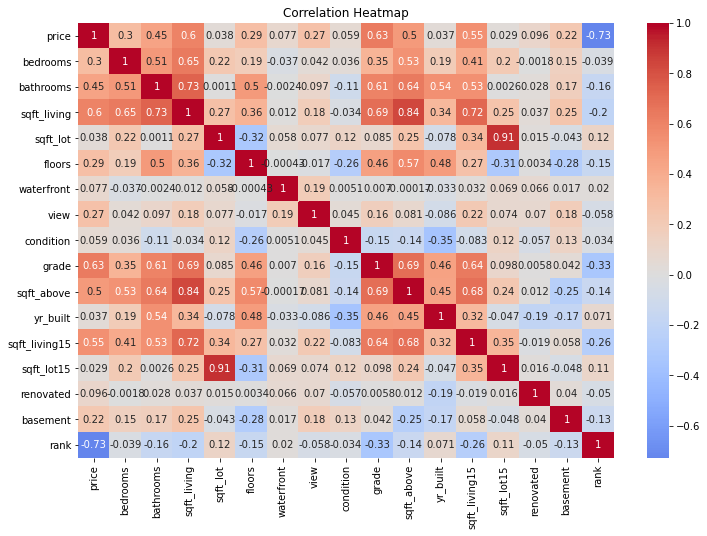

In [590]:
# Plot heatmap
plt.figure(figsize = (12,8))
sns.heatmap(corr, center = 0, annot = True, cmap = 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [591]:
corr

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,renovated,basement,rank
price,1.000000,0.298117,0.450068,0.604596,0.037859,0.286331,0.076759,0.266107,0.058972,0.630984,0.497917,0.036645,0.545650,0.029140,0.096071,0.219348,-0.728044
bedrooms,0.298117,1.000000,0.506614,0.646211,0.222292,0.186379,-0.036719,0.041952,0.036387,0.353718,0.532583,0.191406,0.409192,0.204570,-0.001804,0.150689,-0.038534
bathrooms,0.450068,0.506614,1.000000,0.730022,0.001110,0.497049,-0.002394,0.097409,-0.106817,0.607445,0.642845,0.542441,0.534422,0.002558,0.028008,0.166559,-0.156479
sqft_living,0.604596,0.646211,0.730022,1.000000,0.273918,0.361925,0.011712,0.180861,-0.034465,0.689984,0.836282,0.337518,0.717285,0.253959,0.036595,0.248286,-0.195502
sqft_lot,0.037859,0.222292,0.001110,0.273918,1.000000,-0.319744,0.058261,0.077048,0.119170,0.084570,0.250870,-0.078134,0.336251,0.909960,0.014911,-0.042802,0.118505
floors,0.286331,0.186379,0.497049,0.361925,-0.319744,1.000000,-0.000430,-0.016783,-0.263562,0.460495,0.570358,0.480538,0.270249,-0.307429,0.003356,-0.277706,-0.150594
waterfront,0.076759,-0.036719,-0.002394,0.011712,0.058261,-0.000430,1.000000,0.190964,0.005129,0.006973,-0.000167,-0.033047,0.031520,0.068679,0.066349,0.017251,0.019753
view,0.266107,0.041952,0.097409,0.180861,0.077048,-0.016783,0.190964,1.000000,0.044877,0.164738,0.081103,-0.086481,0.215955,0.073973,0.069704,0.181091,-0.058127
condition,0.058972,0.036387,-0.106817,-0.034465,0.119170,-0.263562,0.005129,0.044877,1.000000,-0.149007,-0.144694,-0.354071,-0.083167,0.124593,-0.057038,0.131149,-0.034039
grade,0.630984,0.353718,0.607445,0.689984,0.084570,0.460495,0.006973,0.164738,-0.149007,1.000000,0.692376,0.459888,0.641103,0.098060,0.005771,0.041720,-0.330802


In [592]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_abs = corr.abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df_abs['pairs'] = list(zip(df_abs.level_0, df_abs.level_1))

# set index to pairs
df_abs.set_index(['pairs'], inplace = True)

#d rop level columns
df_abs.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_abs.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df_abs.drop_duplicates(inplace=True)

In [593]:
abs(df.corr()) > 0.75

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,renovated,basement,rank
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [594]:
df_abs[(df_abs.cc>.75) & (df_abs.cc <1)]

,cc
pairs,
"(sqft_lot15, sqft_lot)",0.909960
"(sqft_above, sqft_living)",0.836282


In [595]:
df.drop(columns=['sqft_above', 'sqft_living15', 'sqft_lot15', 'zipcode'], inplace=True) 

In [596]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'yr_built', 'renovated',
       'basement', 'rank'],
      dtype='object')

In [597]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19545 entries, 0 to 21135
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        19545 non-null  float64
 1   bedrooms     19545 non-null  float64
 2   bathrooms    19545 non-null  float64
 3   sqft_living  19545 non-null  float64
 4   sqft_lot     19545 non-null  float64
 5   floors       19545 non-null  float64
 6   waterfront   19545 non-null  int64  
 7   view         19545 non-null  int64  
 8   condition    19545 non-null  int64  
 9   grade        19545 non-null  int64  
 10  yr_built     19545 non-null  int64  
 11  renovated    19545 non-null  int64  
 12  basement     19545 non-null  int64  
 13  rank         19545 non-null  int64  
dtypes: float64(6), int64(8)
memory usage: 2.9 MB


## One-hot encode Categorical Features

In [598]:
categorical_feats = ['view', 'basement', 'condition', 'grade', 'renovated', 'waterfront', 'yr_built', 'rank']

# Convert to str
for col in categorical_feats:
    df[col] = df[col].astype('str')   

In [599]:
df = pd.get_dummies(df, drop_first = True)

In [600]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
0,-1.448625,-0.234561,-1.716352,-1.110551,-0.315715,-0.922555,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,-1.612827,-1.699959,-1.716352,-1.867599,-0.069677,-0.922555,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.032464,-0.234561,0.437524,0.377035,0.187100,-0.922555,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
3,-1.317501,-0.234561,-1.716352,-0.860609,-0.257744,-0.922555,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,-2.015709,-1.699959,-1.716352,-1.926929,-0.410953,-0.922555,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


Note: This is a lot of columns.

# 4. Model Data

## Model 1: All available features

Perform a train-test split and create an initial regression model to model the price using ALL available features

Note: In order to write the model you'll have to do some tedious manipulation of your column names. Statsmodels will not allow you to have spaces, apostrophe or arithmetic symbols (+) in your column names. Preview them and refine them as you go.
If you receive an error such as "PatsyError: error tokenizing input (maybe an unclosed string?)", then you need to further preprocess your column names.

In [601]:
subs = [(' ', '_'),('.','_'),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_')
       ]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

In [602]:
df.columns = [col_formatting(col) for col in df.columns]

In [603]:
list(df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront_1',
 'view_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_11',
 'grade_12',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'yr_built_1901',
 'yr_built_1902',
 'yr_built_1903',
 'yr_built_1904',
 'yr_built_1905',
 'yr_built_1906',
 'yr_built_1907',
 'yr_built_1908',
 'yr_built_1909',
 'yr_built_1910',
 'yr_built_1911',
 'yr_built_1912',
 'yr_built_1913',
 'yr_built_1914',
 'yr_built_1915',
 'yr_built_1916',
 'yr_built_1917',
 'yr_built_1918',
 'yr_built_1919',
 'yr_built_1920',
 'yr_built_1921',
 'yr_built_1922',
 'yr_built_1923',
 'yr_built_1924',
 'yr_built_1925',
 'yr_built_1926',
 'yr_built_1927',
 'yr_built_1928',
 'yr_built_1929',
 'yr_built_1930',
 'yr_built_1931',
 'yr_built_1932',
 'yr_built_1933',
 'yr_built_1934',
 'yr_built_1935',
 'yr_built_1936',
 'yr_built_1937',
 'yr_built_1938',
 'yr_built_1939',
 'yr_built_1940',
 

In [604]:
# Defining the problem
outcome = 'price'
x_cols = list(df.columns)
x_cols.remove(outcome)

In [605]:
train, test = train_test_split(df)

In [606]:
print(len(train), len(test))
train.head()

14658 4887


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
3050,-0.991974,-0.234561,0.717367,0.289544,-0.163207,1.052297,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
20659,-1.007511,-0.234561,-1.716352,-0.390088,0.119447,-0.922555,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
16807,-0.275804,0.805156,-0.639414,0.302226,0.549318,-0.922555,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
18039,2.071750,0.805156,0.717367,1.947995,0.502596,1.052297,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
13981,0.053879,1.611623,0.970516,0.302226,0.064359,-0.922555,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [607]:
test.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
7364,2.472013,-0.234561,0.717367,0.888197,-0.923951,1.052297,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
20111,-0.806773,-1.699959,-1.716352,-1.291728,-0.778401,0.232660,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
66,-0.346057,1.611623,1.201623,0.806263,0.466830,-0.922555,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
13682,1.178564,0.805156,-0.229981,0.898259,0.257470,-0.922555,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4756,0.223118,-1.699959,-1.716352,-1.067176,-0.173486,-0.922555,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


In [608]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     506.9
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        20:04:05   Log-Likelihood:                -7614.1
No. Observations:               14658   AIC:                         1.552e+04
Df Residuals:                   14512   BIC:                         1.663e+04
Df Model:                         145                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.2535      0.106     11.840      0.000       1.046       1.461
bedrooms         -0.0118      0.005     -2.481      0.013      -0.021      -0.002
bathrooms         0.0492      0.006      7.862      0.000       0.037       0.062
sqft_living       0.3217      0.007     43.222      0.000       0.307       0.336
sqft_lot          0.0389      0.005      7.615      0.000       0.029       0.049
floors           -0.0007      0.006     -0.126      0.900      -0.012       0.011
waterfront_1      1.0256      0.061     16.830      0.000       0.906       1.145
view_1            0.3623      0.013     27.115      0.000       0.336       0.388
condition_2       0.2936      0.097      3.041      0.002       0.104       0.483
condition_3       0.5268      0.089      5.926      0.000       0.353       0.701
condition_4       0.5780      0.089      6.500      0.000       0.404       0.752
condition_5       0.6801      0.089      7.600      0.000       0.505       0.856
grade_11          0.2425      0.053      4.610      0.000       0.139       0.346
grade_12        4.23e-16   1.07e-15      0.395      0.693   -1.68e-15    2.52e-15
grade_3          -0.1202      0.413     -0.291      0.771      -0.931       0.690
grade_4          -1.3587      0.097    -13.988      0.000      -1.549      -1.168
grade_5          -1.3320      0.042    -31.833      0.000      -1.414      -1.250
grade_6          -0.9890      0.027    -36.586      0.000      -1.042      -0.936
grade_7          -0.7020      0.022    -31.628      0.000      -0.745      -0.658
grade_8          -0.4769      0.020    -23.415      0.000      -0.517      -0.437
grade_9          -0.1734      0.021     -8.397      0.000      -0.214      -0.133
yr_built_1901    -0.2455      0.119     -2.061      0.039      -0.479      -0.012
yr_built_1902    -0.1280      0.109     -1.177      0.239      -0.341       0.085
yr_built_1903    -0.2632      0.091     -2.902      0.004      -0.441      -0.085
yr_built_1904     0.0384      0.088      0.435      0.663      -0.135       0.211
yr_built_1905  -9.09e-05      0.078     -0.001      0.999      -0.154       0.154
yr_built_1906    -0.0071      0.075     -0.094      0.925      -0.154       0.140
yr_built_1907     0.0715      0.078      0.911      0.362      -0.082       0.225
yr_built_1908    -0.2453      0.077     -3.198      0.001      -0.396      -0.095
yr_built_1909    -0.0483      0.075     -0.640      0.522      -0.196       0.100
yr_built_1910    -0.0726      0.069     -1.051      0.293      -0.208       0.063
yr_built_1911    -0.0274      0.080     -0.342      0.732      -0.185       0.130
yr_built_1912    -0.1699      0.078     -2.184      0.029      -0.322      -0.017
yr_built_1913     0.0629      0.086      0.731      0.465      -0.106       0.232
yr_built_1914    -0.1506      0.085     -1.777   

## Remove the Uninfluential Features

In [609]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

147 106
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront_1']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,1.2535,0.106,11.840,0.000,1.046,1.461
bedrooms,-0.0118,0.005,-2.481,0.013,-0.021,-0.002
bathrooms,0.0492,0.006,7.862,0.000,0.037,0.062
sqft_living,0.3217,0.007,43.222,0.000,0.307,0.336
sqft_lot,0.0389,0.005,7.615,0.000,0.029,0.049


In [610]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     692.2
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        20:04:06   Log-Likelihood:                -7640.9
No. Observations:               14658   AIC:                         1.550e+04
Df Residuals:                   14551   BIC:                         1.631e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.2161      0.091     13.298      0.000       1.037       1.395
bedrooms         -0.0118      0.005     -2.491      0.013      -0.021      -0.003
bathrooms         0.0486      0.006      7.871      0.000       0.036       0.061
sqft_living       0.3241      0.007     46.093      0.000       0.310       0.338
sqft_lot          0.0365      0.005      7.719      0.000       0.027       0.046
waterfront_1      1.0244      0.061     16.844      0.000       0.905       1.144
view_1            0.3621      0.013     27.256      0.000       0.336       0.388
condition_2       0.2797      0.096      2.912      0.004       0.091       0.468
condition_3       0.5116      0.088      5.785      0.000       0.338       0.685
condition_4       0.5633      0.088      6.367      0.000       0.390       0.737
condition_5       0.6670      0.089      7.493      0.000       0.493       0.842
grade_11          0.2416      0.053      4.593      0.000       0.139       0.345
grade_4          -1.3558      0.097    -14.047      0.000      -1.545      -1.167
grade_5          -1.3356      0.042    -32.159      0.000      -1.417      -1.254
grade_6          -0.9863      0.027    -36.825      0.000      -1.039      -0.934
grade_7          -0.6986      0.022    -31.803      0.000      -0.742      -0.656
grade_8          -0.4751      0.020    -23.428      0.000      -0.515      -0.435
grade_9          -0.1717      0.021     -8.325      0.000      -0.212      -0.131
yr_built_1901    -0.1951      0.106     -1.837      0.066      -0.403       0.013
yr_built_1903    -0.2110      0.073     -2.893      0.004      -0.354      -0.068
yr_built_1908    -0.1928      0.054     -3.541      0.000      -0.300      -0.086
yr_built_1912    -0.1168      0.056     -2.087      0.037      -0.227      -0.007
yr_built_1935    -0.2415      0.106     -2.268      0.023      -0.450      -0.033
yr_built_1936    -0.1732      0.077     -2.261      0.024      -0.323      -0.023
yr_built_1942    -0.1645      0.034     -4.869      0.000      -0.231      -0.098
yr_built_1943    -0.1874      0.037     -5.012      0.000      -0.261      -0.114
yr_built_1944    -0.1727      0.042     -4.155      0.000      -0.254      -0.091
yr_built_1946    -0.0902      0.045     -2.013      0.044      -0.178      -0.002
yr_built_1947    -0.1622      0.032     -5.121      0.000      -0.224      -0.100
yr_built_1948    -0.1500      0.032     -4.628      0.000      -0.214      -0.086
yr_built_1949    -0.1178      0.037     -3.174      0.002      -0.190      -0.045
yr_built_1950    -0.1560      0.033     -4.738      0.000      -0.221      -0.091
yr_built_1951    -0.2020      0.033     -6.042      0.000      -0.268      -0.136
yr_built_1952    -0.1520      0.035     -4.354      0.000      -0.220      -0.084
yr_built_1953    -0.1612      0.034     -4.675   

Note: Model performance is identical.

## Investigate Multicollinearity

Note: There are still a lot of features in the current model. Chances are there are some strong multicollinearity issues. Investigate the extent of this problem.

In [611]:
# VIF quantifies the severity of multicollinearity in an ordinary least squares regression analysis
X = df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bedrooms', 1.9558530466306632),
 ('bathrooms', 3.319614871133222),
 ('sqft_living', 4.293922717372165),
 ('sqft_lot', 1.957413959410809),
 ('waterfront_1', 1.0572946355633273),
 ('view_1', 1.2665203793320166),
 ('condition_2', 1.393996329991424),
 ('condition_3', 34.699602703637645),
 ('condition_4', 14.454034390845058),
 ('condition_5', 4.885332008745584),
 ('grade_11', 1.1306874981105415),
 ('grade_4', 1.1055106641861012),
 ('grade_5', 1.6444040560720297),
 ('grade_6', 5.991597725234567),
 ('grade_7', 17.695816162211383),
 ('grade_8', 10.154128036044067),
 ('grade_9', 4.205147322115459),
 ('yr_built_1901', 1.0111924290088325),
 ('yr_built_1903', 1.01616840866591),
 ('yr_built_1908', 1.0279960315171552),
 ('yr_built_1912', 1.0275990474802976),
 ('yr_built_1935', 1.0122840882835542),
 ('yr_built_1936', 1.0161556895073458),
 ('yr_built_1942', 1.0938434319609074),
 ('yr_built_1943', 1.0794940132576711),
 ('yr_built_1944', 1.062141596246639),
 ('yr_built_1946', 1.0436684110611762),
 ('

## Perform Another Round of Feature Selection

In [612]:
vif_scores = list(zip(x_cols, vif))
x_cols = [x for x,vif in vif_scores if vif < 5]
print(len(vif_scores), len(x_cols))

106 101


In [613]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     641.0
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        20:04:15   Log-Likelihood:                -8400.3
No. Observations:               14658   AIC:                         1.700e+04
Df Residuals:                   14556   BIC:                         1.778e+04
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.1473      0.017     67.220      0.000       1.114       1.181
bedrooms         -0.0310      0.005     -6.270      0.000      -0.041      -0.021
bathrooms         0.0618      0.006      9.589      0.000       0.049       0.074
sqft_living       0.4271      0.007     62.176      0.000       0.414       0.441
sqft_lot          0.0374      0.005      7.600      0.000       0.028       0.047
waterfront_1      1.0353      0.064     16.173      0.000       0.910       1.161
view_1            0.4148      0.014     29.869      0.000       0.388       0.442
condition_2      -0.2777      0.041     -6.769      0.000      -0.358      -0.197
condition_5       0.1201      0.014      8.695      0.000       0.093       0.147
grade_11          0.5483      0.053     10.309      0.000       0.444       0.653
grade_4          -0.3928      0.098     -4.016      0.000      -0.584      -0.201
grade_5          -0.4627      0.035    -13.291      0.000      -0.531      -0.394
grade_9           0.2521      0.013     20.074      0.000       0.227       0.277
yr_built_1901    -0.2474      0.112     -2.215      0.027      -0.466      -0.028
yr_built_1903    -0.2063      0.077     -2.686      0.007      -0.357      -0.056
yr_built_1908    -0.2141      0.057     -3.736      0.000      -0.326      -0.102
yr_built_1912    -0.0860      0.059     -1.459      0.145      -0.201       0.030
yr_built_1935    -0.2676      0.112     -2.389      0.017      -0.487      -0.048
yr_built_1936    -0.2037      0.081     -2.526      0.012      -0.362      -0.046
yr_built_1942    -0.1959      0.036     -5.517      0.000      -0.266      -0.126
yr_built_1943    -0.2257      0.039     -5.748      0.000      -0.303      -0.149
yr_built_1944    -0.2350      0.044     -5.390      0.000      -0.320      -0.150
yr_built_1946    -0.0922      0.047     -1.957      0.050      -0.185       0.000
yr_built_1947    -0.1619      0.033     -4.855      0.000      -0.227      -0.097
yr_built_1948    -0.1511      0.034     -4.427      0.000      -0.218      -0.084
yr_built_1949    -0.1088      0.039     -2.787      0.005      -0.185      -0.032
yr_built_1950    -0.1318      0.035     -3.803      0.000      -0.200      -0.064
yr_built_1951    -0.1802      0.035     -5.123      0.000      -0.249      -0.111
yr_built_1952    -0.1220      0.037     -3.326      0.001      -0.194      -0.050
yr_built_1953    -0.1189      0.036     -3.278      0.001      -0.190      -0.048
yr_built_1954    -0.2501      0.031     -7.994      0.000      -0.311      -0.189
yr_built_1955    -0.2813      0.033     -8.574      0.000      -0.346      -0.217
yr_built_1956    -0.2318      0.038     -6.108      0.000      -0.306      -0.157
yr_built_1957    -0.2819      0.038     -7.504      0.000      -0.355      -0.208
yr_built_1958    -0.3477      0.035     -9.875   

Note: There are still p_values > 0.05

## Remove Uninfluential features

In [614]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

102 98
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront_1']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,1.1473,0.017,67.220,0.0,1.114,1.181
bedrooms,-0.0310,0.005,-6.270,0.0,-0.041,-0.021
bathrooms,0.0618,0.006,9.589,0.0,0.049,0.074
sqft_living,0.4271,0.007,62.176,0.0,0.414,0.441
sqft_lot,0.0374,0.005,7.600,0.0,0.028,0.047


In [615]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     660.4
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        20:04:16   Log-Likelihood:                -8404.1
No. Observations:               14658   AIC:                         1.701e+04
Df Residuals:                   14559   BIC:                         1.776e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.1409      0.017     67.489      0.000       1.108       1.174
bedrooms         -0.0309      0.005     -6.241      0.000      -0.041      -0.021
bathrooms         0.0615      0.006      9.569      0.000       0.049       0.074
sqft_living       0.4269      0.007     62.148      0.000       0.413       0.440
sqft_lot          0.0375      0.005      7.635      0.000       0.028       0.047
waterfront_1      1.0346      0.064     16.161      0.000       0.909       1.160
view_1            0.4154      0.014     29.922      0.000       0.388       0.443
condition_2      -0.2778      0.041     -6.771      0.000      -0.358      -0.197
condition_5       0.1204      0.014      8.720      0.000       0.093       0.147
grade_11          0.5483      0.053     10.307      0.000       0.444       0.653
grade_4          -0.4023      0.098     -4.118      0.000      -0.594      -0.211
grade_5          -0.4619      0.035    -13.269      0.000      -0.530      -0.394
grade_9           0.2510      0.013     20.058      0.000       0.226       0.276
yr_built_1901    -0.2410      0.112     -2.158      0.031      -0.460      -0.022
yr_built_1903    -0.2001      0.077     -2.607      0.009      -0.351      -0.050
yr_built_1908    -0.2079      0.057     -3.631      0.000      -0.320      -0.096
yr_built_1935    -0.2615      0.112     -2.335      0.020      -0.481      -0.042
yr_built_1936    -0.1974      0.081     -2.449      0.014      -0.355      -0.039
yr_built_1942    -0.1898      0.035     -5.355      0.000      -0.259      -0.120
yr_built_1943    -0.2197      0.039     -5.604      0.000      -0.297      -0.143
yr_built_1944    -0.2288      0.044     -5.253      0.000      -0.314      -0.143
yr_built_1947    -0.1555      0.033     -4.674      0.000      -0.221      -0.090
yr_built_1948    -0.1447      0.034     -4.250      0.000      -0.211      -0.078
yr_built_1949    -0.1024      0.039     -2.628      0.009      -0.179      -0.026
yr_built_1950    -0.1255      0.035     -3.630      0.000      -0.193      -0.058
yr_built_1951    -0.1738      0.035     -4.953      0.000      -0.243      -0.105
yr_built_1952    -0.1157      0.037     -3.160      0.002      -0.188      -0.044
yr_built_1953    -0.1125      0.036     -3.110      0.002      -0.183      -0.042
yr_built_1954    -0.2437      0.031     -7.812      0.000      -0.305      -0.183
yr_built_1955    -0.2750      0.033     -8.402      0.000      -0.339      -0.211
yr_built_1956    -0.2254      0.038     -5.949      0.000      -0.300      -0.151
yr_built_1957    -0.2753      0.037     -7.345      0.000      -0.349      -0.202
yr_built_1958    -0.3413      0.035     -9.714      0.000      -0.410      -0.272
yr_built_1959    -0.3194      0.029    -10.999      0.000      -0.376      -0.263
yr_built_1960    -0.3211      0.034     -9.343   

Note: No p-values > 0.05!

## Check the Normality Assumption

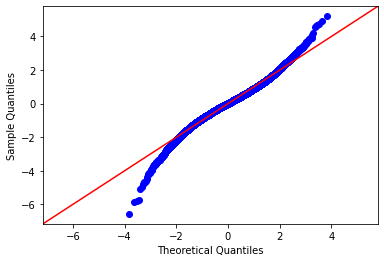

In [616]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

Note: There appears to be some issues with the residuals not being normally distributed.

This displays a fairly pronounced 'funnel' shape: errors appear to increase as the list_price decreases and increases. This doesn't bode well for our model. Subsetting the data to remove outliers and confining the model to this restricted domain may be necessary. A log transformation or something equivalent may also be appropriate.

## Check Homoscedasticity Assumption

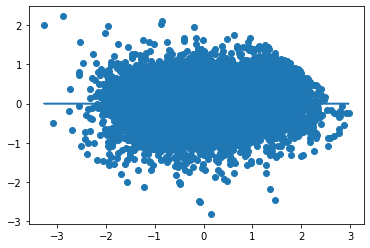

In [617]:
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

Note: There is no strong evidence of heteroscedasticity (unequal scatter of residuals).

## Evaluate Model using sci-kit learn's cross_val_score

In [618]:
# Define X_train and y_train. As single feature need to reshape X_train into column vector
X_train = train[x_cols]
y_train = train['price']

# Create linear regression object
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([0.44593087, 0.45015839, 0.41402517, 0.4426124 , 0.41898988,
       0.43757285, 0.41981434, 0.43029525, 0.43349553, 0.4335746 ])

0.4326469288390428

0.011453213354860724

# Model 2: Select Features

Note: Removed features based on linear analysis performed above
- yr_built features
- sqft_lot
- floors
- basement_1
- grade_3
- grade_4
- grade_12

In [619]:
model_2_df = df[['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'waterfront_1',
 'view_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'renovated_1',
 'grade_11',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'rank_10',
 'rank_2',
 'rank_3',
 'rank_4',
 'rank_5',
 'rank_6',
 'rank_7',
 'rank_8',
 'rank_9']]

In [620]:
model_2_df.head()

,price,bedrooms,bathrooms,sqft_living,waterfront_1,view_1,condition_2,condition_3,condition_4,condition_5,...,grade_9,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
0,-1.448625,-0.234561,-1.716352,-1.110551,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-1.612827,-1.699959,-1.716352,-1.867599,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0.032464,-0.234561,0.437524,0.377035,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-1.317501,-0.234561,-1.716352,-0.860609,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-2.015709,-1.699959,-1.716352,-1.926929,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [621]:
# Defining the problem
outcome = 'price'
x_cols = list(model_2_df.columns)
x_cols.remove(outcome)

In [622]:
print(len(train), len(test))
train.head()

14658 4887


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
3050,-0.991974,-0.234561,0.717367,0.289544,-0.163207,1.052297,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
20659,-1.007511,-0.234561,-1.716352,-0.390088,0.119447,-0.922555,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
16807,-0.275804,0.805156,-0.639414,0.302226,0.549318,-0.922555,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
18039,2.071750,0.805156,0.717367,1.947995,0.502596,1.052297,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
13981,0.053879,1.611623,0.970516,0.302226,0.064359,-0.922555,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [623]:
test.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
7364,2.472013,-0.234561,0.717367,0.888197,-0.923951,1.052297,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
20111,-0.806773,-1.699959,-1.716352,-1.291728,-0.778401,0.232660,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
66,-0.346057,1.611623,1.201623,0.806263,0.466830,-0.922555,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
13682,1.178564,0.805156,-0.229981,0.898259,0.257470,-0.922555,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4756,0.223118,-1.699959,-1.716352,-1.067176,-0.173486,-0.922555,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


In [624]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     2576.
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        20:04:17   Log-Likelihood:                -8464.2
No. Observations:               14658   AIC:                         1.698e+04
Df Residuals:                   14632   BIC:                         1.718e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8238      0.095      8.636      0.000       0.637       1.011
bedrooms        -0.0179      0.005     -3.684      0.000      -0.027      -0.008
bathrooms       -0.0132      0.006     -2.369      0.018      -0.024      -0.002
sqft_living      0.3750      0.007     55.030      0.000       0.362       0.388
waterfront_1     1.0271      0.064     16.079      0.000       0.902       1.152
view_1           0.4106      0.014     30.042      0.000       0.384       0.437
condition_2      0.2379      0.101      2.357      0.018       0.040       0.436
condition_3      0.4588      0.093      4.936      0.000       0.277       0.641
condition_4      0.5267      0.093      5.665      0.000       0.344       0.709
condition_5      0.6927      0.094      7.405      0.000       0.509       0.876
renovated_1      0.2260      0.021     10.978      0.000       0.186       0.266
grade_11         0.2503      0.055      4.541      0.000       0.142       0.358
grade_5         -0.9827      0.042    -23.474      0.000      -1.065      -0.901
grade_6         -0.7155      0.026    -27.430      0.000      -0.767      -0.664
grade_7         -0.5504      0.022    -25.546      0.000      -0.593      -0.508
grade_8         -0.3828      0.020    -18.834      0.000      -0.423      -0.343
grade_9         -0.0930      0.021     -4.398      0.000      -0.134      -0.052
rank_10         -1.8600      0.019    -96.783      0.000      -1.898      -1.822
rank_2          -0.2299      0.019    -12.300      0.000      -0.267      -0.193
rank_3          -0.4634      0.017    -27.438      0.000      -0.497      -0.430
rank_4          -0.3465      0.017    -19.876      0.000      -0.381      -0.312
rank_5          -0.7726      0.019    -39.868      0.000      -0.811      -0.735
rank_6          -0.9606      0.018    -53.583      0.000      -0.996      -0.925
rank_7          -1.0532      0.017    -60.307      0.000      -1.087      -1.019
rank_8          -1.4872      0.018    -84.086      0.000      -1.522      -1.453
rank_9          -1.7953      0.018    -99.577      0.000      -1.831      -1.760
==============================================================================
Omnibus:                      572.796   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1787.083
Skew:                          -0.047   Prob(JB):                         0.00
Kurtosis:                       4.708   Cond. No.                         89.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Remove Uninfluential Features

In [625]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

26 25
['bedrooms', 'bathrooms', 'sqft_living', 'waterfront_1', 'view_1']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,0.8238,0.095,8.636,0.000,0.637,1.011
bedrooms,-0.0179,0.005,-3.684,0.000,-0.027,-0.008
bathrooms,-0.0132,0.006,-2.369,0.018,-0.024,-0.002
sqft_living,0.3750,0.007,55.030,0.000,0.362,0.388
waterfront_1,1.0271,0.064,16.079,0.000,0.902,1.152


In [626]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     2576.
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        20:04:17   Log-Likelihood:                -8464.2
No. Observations:               14658   AIC:                         1.698e+04
Df Residuals:                   14632   BIC:                         1.718e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8238      0.095      8.636      0.000       0.637       1.011
bedrooms        -0.0179      0.005     -3.684      0.000      -0.027      -0.008
bathrooms       -0.0132      0.006     -2.369      0.018      -0.024      -0.002
sqft_living      0.3750      0.007     55.030      0.000       0.362       0.388
waterfront_1     1.0271      0.064     16.079      0.000       0.902       1.152
view_1           0.4106      0.014     30.042      0.000       0.384       0.437
condition_2      0.2379      0.101      2.357      0.018       0.040       0.436
condition_3      0.4588      0.093      4.936      0.000       0.277       0.641
condition_4      0.5267      0.093      5.665      0.000       0.344       0.709
condition_5      0.6927      0.094      7.405      0.000       0.509       0.876
renovated_1      0.2260      0.021     10.978      0.000       0.186       0.266
grade_11         0.2503      0.055      4.541      0.000       0.142       0.358
grade_5         -0.9827      0.042    -23.474      0.000      -1.065      -0.901
grade_6         -0.7155      0.026    -27.430      0.000      -0.767      -0.664
grade_7         -0.5504      0.022    -25.546      0.000      -0.593      -0.508
grade_8         -0.3828      0.020    -18.834      0.000      -0.423      -0.343
grade_9         -0.0930      0.021     -4.398      0.000      -0.134      -0.052
rank_10         -1.8600      0.019    -96.783      0.000      -1.898      -1.822
rank_2          -0.2299      0.019    -12.300      0.000      -0.267      -0.193
rank_3          -0.4634      0.017    -27.438      0.000      -0.497      -0.430
rank_4          -0.3465      0.017    -19.876      0.000      -0.381      -0.312
rank_5          -0.7726      0.019    -39.868      0.000      -0.811      -0.735
rank_6          -0.9606      0.018    -53.583      0.000      -0.996      -0.925
rank_7          -1.0532      0.017    -60.307      0.000      -1.087      -1.019
rank_8          -1.4872      0.018    -84.086      0.000      -1.522      -1.453
rank_9          -1.7953      0.018    -99.577      0.000      -1.831      -1.760
==============================================================================
Omnibus:                      572.796   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1787.083
Skew:                          -0.047   Prob(JB):                         0.00
Kurtosis:                       4.708   Cond. No.                         89.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Evaluate Model using sci-kit learn's cross_val_score

In [627]:
# Define X_train and y_train. As single feature need to reshape X_train into column vector
X_train = train[x_cols]
y_train = train['price']

# Create linear regression object
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([0.4472727 , 0.44492874, 0.41092592, 0.45144181, 0.42309551,
       0.43428624, 0.42267107, 0.43628463, 0.4223045 , 0.4288779 ])

0.4322089029467898

0.0123114819954685

# Check the Normality Assumption

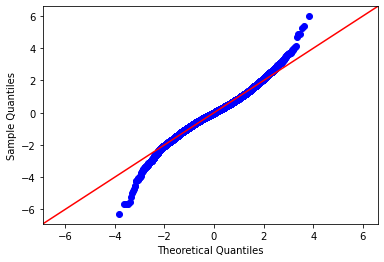

In [628]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

## Check Homoscedasticity Assumption

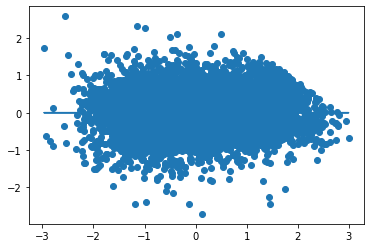

In [629]:
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

## Investigate Multicollinearity

In [630]:
# Your code here
X = model_2_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bedrooms', 1.859210480733302),
 ('bathrooms', 2.4453591644958643),
 ('sqft_living', 3.632001842990968),
 ('waterfront_1', 1.050215800578558),
 ('view_1', 1.2119512626456885),
 ('condition_2', 1.2926550733607525),
 ('condition_3', 25.97165625830833),
 ('condition_4', 11.394440025453566),
 ('condition_5', 4.19292856920942),
 ('renovated_1', 1.0565051207214702),
 ('grade_11', 1.1176244271861029),
 ('grade_5', 1.5228907576205852),
 ('grade_6', 5.18652006503679),
 ('grade_7', 15.560533204649902),
 ('grade_8', 9.291637532284739),
 ('grade_9', 4.005908534137679),
 ('rank_10', 2.3128460443228818),
 ('rank_2', 2.1037412817673258),
 ('rank_3', 3.018860121411673),
 ('rank_4', 2.7971824446084192),
 ('rank_5', 2.0689074437257164),
 ('rank_6', 2.6097191303616163),
 ('rank_7', 2.980928554775727),
 ('rank_8', 2.84051158849248),
 ('rank_9', 2.577680138062751)]

## Perform Another Round of Feature Selection

In [631]:
vif_scores = list(zip(x_cols, vif))
x_cols = [x for x,vif in vif_scores if vif < 5]
print(len(vif_scores), len(x_cols))

25 20


In [632]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     2987.
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        20:04:18   Log-Likelihood:                -8911.5
No. Observations:               14658   AIC:                         1.787e+04
Df Residuals:                   14637   BIC:                         1.802e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8937      0.014     61.639      0.000       0.865       0.922
bedrooms        -0.0377      0.005     -7.634      0.000      -0.047      -0.028
bathrooms        0.0162      0.005      2.980      0.003       0.006       0.027
sqft_living      0.4483      0.007     68.485      0.000       0.435       0.461
waterfront_1     1.0327      0.066     15.689      0.000       0.904       1.162
view_1           0.4358      0.014     31.033      0.000       0.408       0.463
condition_2     -0.2483      0.042     -5.900      0.000      -0.331      -0.166
condition_5      0.1700      0.014     12.394      0.000       0.143       0.197
renovated_1      0.1894      0.021      8.955      0.000       0.148       0.231
grade_11         0.5325      0.054      9.790      0.000       0.426       0.639
grade_5         -0.3516      0.035     -9.948      0.000      -0.421      -0.282
grade_9          0.2642      0.013     21.061      0.000       0.240       0.289
rank_10         -1.9538      0.019   -100.343      0.000      -1.992      -1.916
rank_2          -0.2442      0.019    -12.730      0.000      -0.282      -0.207
rank_3          -0.5005      0.017    -29.008      0.000      -0.534      -0.467
rank_4          -0.3952      0.018    -22.152      0.000      -0.430      -0.360
rank_5          -0.8496      0.020    -43.116      0.000      -0.888      -0.811
rank_6          -1.0432      0.018    -57.526      0.000      -1.079      -1.008
rank_7          -1.1393      0.018    -64.397      0.000      -1.174      -1.105
rank_8          -1.5767      0.018    -88.278      0.000      -1.612      -1.542
rank_9          -1.8786      0.018   -102.583      0.000      -1.914      -1.843
==============================================================================
Omnibus:                      505.498   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1442.660
Skew:                          -0.055   Prob(JB):                         0.00
Kurtosis:                       4.533   Cond. No.                         27.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [633]:
# Define X_train and y_train. As single feature need to reshape X_train into column vector
X_train = train[x_cols]
y_train = train['price']

# Create linear regression object
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([0.46066105, 0.45962066, 0.43081622, 0.45675551, 0.4332744 ,
       0.44312425, 0.43125161, 0.45061034, 0.440686  , 0.44443878])

0.44512388082819465

0.010856694995275518

In [634]:
# Save model
#tuple_objects = (linreg, X_train, y_train)
#pickle.dump(tuple_objects, open('model_3.pkl','wb'))

# Predictions with test data

In [635]:
test.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront_1,view_1,condition_2,condition_3,...,basement_1,rank_10,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9
7364,2.472013,-0.234561,0.717367,0.888197,-0.923951,1.052297,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
20111,-0.806773,-1.699959,-1.716352,-1.291728,-0.778401,0.232660,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
66,-0.346057,1.611623,1.201623,0.806263,0.466830,-0.922555,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
13682,1.178564,0.805156,-0.229981,0.898259,0.257470,-0.922555,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4756,0.223118,-1.699959,-1.716352,-1.067176,-0.173486,-0.922555,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


In [636]:
len(test)

4887

In [637]:
# Fitting the actual model
outcome = 'price'
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=test).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     979.1
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        20:04:19   Log-Likelihood:                -2962.2
No. Observations:                4887   AIC:                             5966.
Df Residuals:                    4866   BIC:                             6103.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8514      0.025     34.200      0.000       0.803       0.900
bedrooms        -0.0439      0.009     -5.155      0.000      -0.061      -0.027
bathrooms        0.0339      0.009      3.580      0.000       0.015       0.052
sqft_living      0.4521      0.011     40.183      0.000       0.430       0.474
waterfront_1     0.9474      0.118      8.055      0.000       0.717       1.178
view_1           0.3986      0.025     15.990      0.000       0.350       0.447
condition_2     -0.4691      0.076     -6.180      0.000      -0.618      -0.320
condition_5      0.2191      0.024      9.284      0.000       0.173       0.265
renovated_1      0.1912      0.036      5.386      0.000       0.122       0.261
grade_11         0.4578      0.103      4.429      0.000       0.255       0.660
grade_5         -0.1452      0.062     -2.330      0.020      -0.267      -0.023
grade_9          0.2335      0.022     10.564      0.000       0.190       0.277
rank_10         -1.9298      0.033    -58.874      0.000      -1.994      -1.866
rank_2          -0.2268      0.033     -6.819      0.000      -0.292      -0.162
rank_3          -0.4755      0.029    -16.156      0.000      -0.533      -0.418
rank_4          -0.3498      0.030    -11.495      0.000      -0.409      -0.290
rank_5          -0.7923      0.035    -22.731      0.000      -0.861      -0.724
rank_6          -0.9856      0.032    -31.158      0.000      -1.048      -0.924
rank_7          -1.0777      0.031    -35.307      0.000      -1.138      -1.018
rank_8          -1.5815      0.031    -51.325      0.000      -1.642      -1.521
rank_9          -1.8373      0.032    -58.025      0.000      -1.899      -1.775
==============================================================================
Omnibus:                      133.214   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              330.106
Skew:                          -0.024   Prob(JB):                     2.08e-72
Kurtosis:                       4.272   Cond. No.                         27.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [638]:
len(x_cols)

20

## Interpret results

- Adj. R-squared:	0.798 = model adequately predicts sales price
- No p-values > 0.05 = features statistically significant

- bedrooms surprsingly had a negative impact on price
- having a waterfront had the highest impact on price
- sqft_living, view, rennovation had a postiive impact on price
- higher grades and conditions have positive impacts on price
- zip ranks negatively impacted price, but better rankings were less impactful

In [639]:
# Define X_train and y_train. As single feature need to reshape X_train into column vector
X_test = test[x_cols]
y_test = test['price']

# Create linear regression object
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_test, y_test)

scores = cross_val_score(
            linreg, 
            X_test,
            y_test,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([0.4284232 , 0.40919162, 0.47981219, 0.42025176, 0.43946042,
       0.44091446, 0.45671249, 0.45444969, 0.4622359 , 0.4732513 ])

0.44647030202912336

0.021745911614391444

Note: 
Train
- Mean: 0.4470255494531881
- Std: 0.010111087373147571

Based on a rule of thumb, it can be said that RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately.

## Check the Normality Assumption

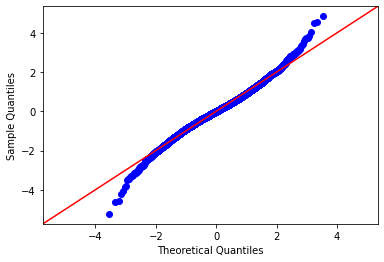

In [640]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

## Check Homoscedasticity Assumption

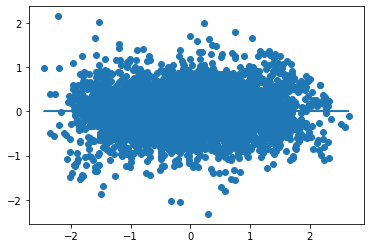

In [641]:
plt.scatter(model.predict(test[x_cols]), model.resid)
plt.plot(model.predict(test[x_cols]), [0 for i in range(len(test))])